In [381]:
import os
import numpy as np
import pandas as pd
import tempfile

import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as pplt
import matplotlib.pyplot as plt
from pandapower.plotting.plotly import pf_res_plotly
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl

In [382]:
net = nw.create_cigre_network_mv()

In [383]:
#importing the active and reactive power of loads from excel
df_active = pd.read_csv('active_power_time_series_ev_load.csv')
df_reactive = pd.read_csv('reactive_power_time_series_ev_load.csv')
# create the data source from
ds_active = DFData(df_active)
ds_reactive = DFData(df_reactive)

In [384]:
df_active

,Load R1,Load R3,Load R4,Load R5,Load R6,Load R8,Load R10,Load R11,Load R12,Load R14,...,Vehicle 991,Vehicle 992,Vehicle 993,Vehicle 994,Vehicle 995,Vehicle 996,Vehicle 997,Vehicle 998,Vehicle 999,Vehicle 1000
0,4.241053,0.078194,0.122092,0.205773,0.155016,0.165991,0.134439,0.093284,4.241053,0.058988,...,0.06,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,4.082791,0.075276,0.117536,0.198095,0.149231,0.159796,0.129422,0.089803,4.082791,0.056787,...,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,3.919174,0.072259,0.112826,0.190156,0.143251,0.153392,0.124235,0.086204,3.919174,0.054511,...,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,3.918352,0.072244,0.112802,0.190116,0.143221,0.153360,0.124209,0.086186,3.918352,0.054500,...,0.00,0,0,0.00,0.00,0.06,0.00,0.00,0.00,0.00
4,3.813214,0.070306,0.109776,0.185015,0.139378,0.149245,0.120876,0.083873,3.813214,0.053038,...,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.06,0.00
5,3.895276,0.071819,0.112138,0.188996,0.142377,0.152457,0.123478,0.085678,3.895276,0.054179,...,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.06,0.00
6,4.092852,0.075461,0.117826,0.198583,0.149599,0.160190,0.129741,0.090024,4.092852,0.056927,...,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,4.635395,0.085465,0.133445,0.224907,0.169430,0.181425,0.146939,0.101958,4.635395,0.064473,...,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,6.507081,0.119973,0.187327,0.315720,0.237842,0.254681,0.206270,0.143126,6.507081,0.090506,...,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,8.141067,0.150100,0.234367,0.395000,0.297566,0.318633,0.258067,0.179067,8.141067,0.113233,...,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [385]:
def timeseries_example(output_dir):
    
    #defing the time step
    n_timesteps = 24
    
    # 3. create controllers (to control P values of the load) ds_p is for active power and ds_q for reactive power
    create_controllers(net, ds_active, ds_reactive)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps) 

In [386]:
def create_controllers(net,ds_active,ds_reactive):
    load_index=net.load.index
    load_name=net.load.name
    
    for i in range(len(load_index)):
        ConstControl(net, element='load', variable='p_mw', element_index=load_index[i],
                 data_source=ds_active, profile_name=load_name[i])
        ConstControl(net, element='load', variable='q_mvar', element_index=load_index[i],
                 data_source=ds_reactive, profile_name=load_name[i])

In [387]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    ow.log_variable('res_trafo','loading_percent')
    return ow

In [388]:
#creating our net
pp.create_bus(net, name='Bus CS 14', vn_kv=0.4, type='b', geodata=((10,3.5)))
pp.create_bus(net, name='Bus CS 11', vn_kv=0.4, type='b', geodata=((2.5,7)))
pp.create_bus(net, name='Bus CS 5', vn_kv=0.4, type='b', geodata=((-0.5,7)))
pp.create_bus(net, name='Bus CS 4', vn_kv=0.4, type='b', geodata=((1,9)))
pp.create_bus(net, name='Bus CS 9', vn_kv=0.4, type='b', geodata=((6,3.5)))


pp.create_transformer(net, hv_bus=14, lv_bus= pp.get_element_index(net,'bus', 'Bus CS 14'), name='CS 14', std_type= '0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=11, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS 11'),  name='CS 11',std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=5, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 5'),   name='CS 5', std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=4, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 4'),   name='CS 4', std_type= '0.25 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=9, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 9'),   name='CS 9', std_type= '0.25 MVA 20/0.4 kV')

net.switch.closed[1] = True
net.switch.closed[2] = True
net.switch.closed[4] = True

   

for i in range (1,46):
    l = str(i)
    pp.create_load(net, bus=15, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)
   
 #Bus CS 11 (0.4 MVA) - trafo id: 3
for i in range (46,70):
    l = str(i)
    pp.create_load(net, bus=16, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)
    
#Bus CS 5 (0.4 MVA) - trafo id: 4
for i in range (70,91):
    l = str(i)
    pp.create_load(net, bus=17, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

#Bus CS 4 (0.25 MVA) - trafo id: 5
for i in range (91,104):
    l = str(i)
    pp.create_load(net, bus=18, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)
    
#Bus CS 9 (0.25 MVA)- trafo id: 6
for i in range (104,117):
    l = str(i)
    pp.create_load(net, bus=19, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)        
    
output_dir = os.path.join(tempfile.gettempdir(), "time_series_ev")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

Results can be found in your local temp folder: C:\Users\jithu\AppData\Local\Temp\time_series_ev




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:03<01:09,  3.00s/it]

 25%|██▌       | 6/24 [00:03<00:06,  2.57it/s]

 50%|█████     | 12/24 [00:03<00:01,  6.02it/s]

 75%|███████▌  | 18/24 [00:03<00:00, 10.12it/s]

100%|██████████| 24/24 [00:03<00:00,  6.33it/s]


In [389]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,Load R1,1,4.467702,0.907206,0.0,0.0,15.300,1.0,True,wye
1,Load R3,3,0.082373,0.020645,0.0,0.0,0.285,1.0,True,wye
2,Load R4,4,0.128617,0.032235,0.0,0.0,0.445,1.0,True,wye
3,Load R5,5,0.216770,0.054328,0.0,0.0,0.750,1.0,True,wye
4,Load R6,6,0.163300,0.040927,0.0,0.0,0.565,1.0,True,wye
...,...,...,...,...,...,...,...,...,...,...
129,Vehicle 112,19,0.000000,0.000000,0.0,0.0,NaN,1.0,True,wye
130,Vehicle 113,19,0.000000,0.000000,0.0,0.0,NaN,1.0,True,wye
131,Vehicle 114,19,0.000000,0.000000,0.0,0.0,NaN,1.0,True,wye
132,Vehicle 115,19,0.000000,0.000000,0.0,0.0,NaN,1.0,True,wye


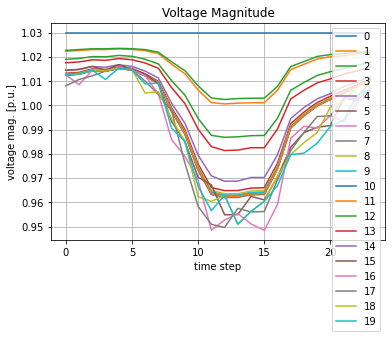

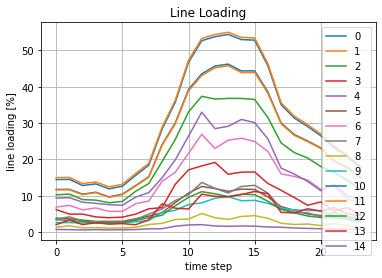

100%|██████████| 24/24 [03:43<00:00,  9.33s/it]


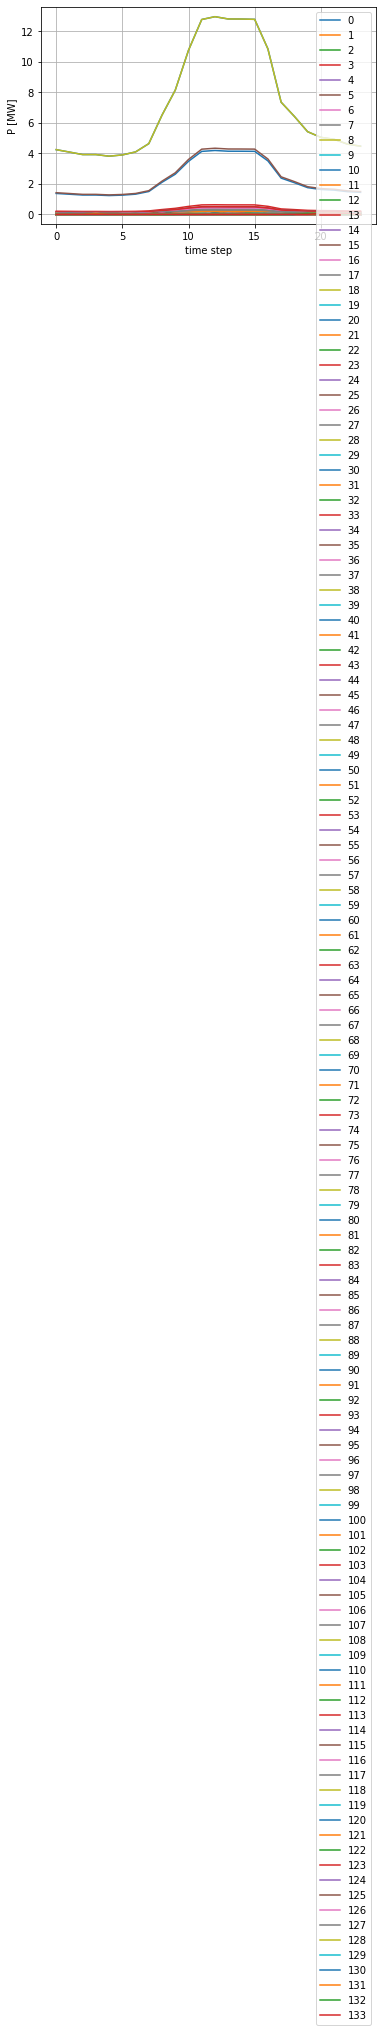

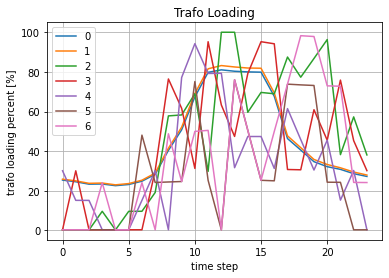

In [390]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()

#trafo results
load_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="trafo")
plt.xlabel("time step")
plt.ylabel("trafo loading percent [%]")
plt.title("Trafo Loading")
plt.grid()
plt.show()